## Using ARGMINN for motif/syntax discovery

In this notebook, we will walk through how to use the ARGMINN architecture to discover motifs and syntax from a genome-regulatory experiment (e.g. ChIP-seq).

If you haven't already, check out the corresponding literature linked to in the [README](https://github.com/Genentech/ARGMINN).

This notebook is meant to be entirely self-sufficient, relying only on common external libraries (e.g. PyTorch). As such, the full architecture and loss functions are defined in this file.

In [1]:
# Import external libraries
import numpy as np
import pandas as pd
import torch
import math
import pysam
import os
import tqdm.notebook
import logomaker
import matplotlib.pyplot as plt

In [2]:
if torch.cuda.is_available():
    DEVICE = "cuda"
else:
    DEVICE = "cpu"

### 1) Define the ARGMINN architecture
Let's start off by defining the ARGMINN architecture. The loss functions (including for regularization) are included in the model architecture below.

To make things more readable, we break up the model architecture into three PyTorch classes.

First, we'll define the architecture of a single attention layer in the syntax-building module. Each such layer takes in a memory stream `stream`, and the set of input tokens (which will consist of the concatenated motif-scanner activations and positional encodings). The layer will then compute key/value vectors from the input tokens, as well as a single query vector from the memory stream. Scaled-dot-product attention is then performed and the result is used to update the memory stream (which is returned).

In [3]:
class StreamAttentionLayer(torch.nn.Module):
    def __init__(
        self, input_dim, stream_dim, mlp_hidden_dim, num_heads,
        dropout_rate=0.1, norm=True
    ):
        """
        Initializes a single layer of a stream-based attention mechanism, where
        there is a smaller number of queries which are not derived from input
        tokens.
        Arguments:
            `input_dim`: the dimension of the input tokens, E
            `stream_dim`: the dimension of the stream, E'
            `mlp_hidden_dim`: dimension of the hidden layer of the MLP
            `num_heads`: number of attention heads, NH; must be a factor of E
            `dropout_rate`: dropout rate
            `norm`: whether or not to perform normalization
        """
        super().__init__()

        assert input_dim % num_heads == 0

        self.model_dim = input_dim
        self.num_heads = num_heads
        
        # Multi-headed attention
        self.att_query_linear = torch.nn.Linear(stream_dim, input_dim)
        self.att_key_linear = torch.nn.Linear(input_dim, input_dim)
        self.att_value_linear = torch.nn.Linear(input_dim, input_dim)
        self.att_dropout = torch.nn.Dropout(dropout_rate)
        self.att_final_linear = torch.nn.Linear(input_dim, input_dim)

        self.post_att_dropout = torch.nn.Dropout(dropout_rate)
        if norm:
            self.post_att_norm = torch.nn.LayerNorm(input_dim)
        else:
            self.post_att_norm = lambda x: x

        # Feed-forward
        self.feedforward = torch.nn.Sequential(
            torch.nn.Linear(input_dim, mlp_hidden_dim),
            torch.nn.ReLU(),
            torch.nn.Dropout(dropout_rate),
            torch.nn.Linear(mlp_hidden_dim, stream_dim)
        )
        
        self.post_ff_dropout = torch.nn.Dropout(dropout_rate)
        if norm:
            self.post_ff_norm = torch.nn.LayerNorm(stream_dim)
        else:
            self.post_ff_norm = lambda x: x

    def forward(self, input_tokens, stream, return_interims=False):
        """
        Runs the forward pass of the layer.
        Arguments:
            `input_tokens`: a B x L' x E tensor of input tokens
            `stream`: a B x E' tensor of the stream
            `return_interims`: if True, also return a dictionary containing the
                attention values
        Returns a B x E' tensor as an updated stream. If `return_interims` is
        True, also returns a dictionary containing a B x NH x L' tensor of the
        attention values (post-softmax).
        """
        # Map to query/key/value
        query = self.att_query_linear(stream)
        key = self.att_key_linear(input_tokens)
        value = self.att_value_linear(input_tokens)
        
        # Reshape to extract head dimension
        batch_size, num_tokens = input_tokens.shape[0], input_tokens.shape[1]
        shape_1 = (batch_size, 1, self.num_heads, -1)
        shape_2 = (batch_size, num_tokens, self.num_heads, -1)
        query = query.view(*shape_1).transpose(1, 2)  # Shape: B x NH x 1 x D'
        key = key.view(*shape_2).transpose(1, 2)  # Shape: B x NH x L' x D'
        value = value.view(*shape_2).transpose(1, 2)  # Shape: B x NH x L' x D'

        # Compute attention scores
        att_vals = torch.matmul(query, value.transpose(2, 3))
        # Shape: B x NH x 1 x L'
        att_vals = att_vals / math.sqrt(query.shape[3])
        att_vals = self.att_dropout(att_vals)
        att_vals = torch.softmax(att_vals, dim=-1)

        if return_interims:
            interims = {"att_vals": torch.squeeze(att_vals, dim=2)}

        # Compute value-vector weighted sums
        value_sums = torch.matmul(att_vals, value)  # Shape: B x NH x 1 x D'

        # Reshape to reincorporate heads
        value_sums = value_sums.transpose(1, 2).contiguous().view(
            batch_size, -1
        )  # Shape: B x E

        # Last linear of attention
        att_out = self.att_final_linear(value_sums)

        # Post-attention dropout, norm
        post_att_out = self.post_att_norm(self.post_att_dropout(att_out))
        
        # Feed-forward
        ff_out = self.feedforward(post_att_out)

        # Post-feed-forward dropout, residual, norm
        post_ff_out = self.post_ff_norm(self.post_ff_dropout(ff_out))
        # Shape: B x E'

        if return_interims:
            return post_ff_out, interims
        else:
            return post_ff_out

Next, let's define the full syntax-builder module, which consists of a stack of these attention layers. The initial memory stream is initialized to all 1s. The syntax-builder module takes in the input tokens, and it will internally initialize the memory stream. Then, it will pass the input tokens and the memory stream to each attention layer in succession, and return a final modified memory stream. 

In [4]:
class SyntaxBuilderStreamAttention(torch.nn.Module):
    def __init__(
        self, num_att_layers, input_token_dim, pos_enc_dim, stream_dim,
        att_hidden_dim, att_mlp_hidden_dim, att_num_heads, dropout_rate=0.1,
        norm=True
    ):
        """
        Initializes a syntax-building stream-attention module, which takes in
        motif tokens with the positional embedding, and outputs a vector
        embedding.
        Arguments:
            `num_att_layers`: number of attention layers, AL
            `input_token_dim`: dimension of each input token, E
            `pos_enc_dim`: dimension of positional encoding, D'
            `stream_dim`: dimension of memory stream, E'
            `att_hidden_dim`: dimension of query/key vectors in attentions
            `att_mlp_hidden_dim`: dimension of MLP
            `att_num_heads`: number of attention heads, NH
            `dropout_rate`: dropout rate for attention mechanism
            `norm`: whether or not to include normalization in attention
        """
        super().__init__()

        self.init_stream = torch.nn.Parameter(
            torch.ones(stream_dim), requires_grad=False
        )

        self.init_dense = torch.nn.Linear(
            input_token_dim + pos_enc_dim, att_hidden_dim
        )

        self.attention_layers = torch.nn.ModuleList([
            StreamAttentionLayer(
                att_hidden_dim, stream_dim, att_mlp_hidden_dim, att_num_heads,
                dropout_rate, norm
            ) for _ in range(num_att_layers)
        ])
        if norm:
            self.final_norm = torch.nn.LayerNorm(stream_dim)
        else:
            self.final_norm = lambda x: x

    def forward(self, input_tokens, pos_enc, return_interims=False):
        """
        Runs the forward pass of the model.
        Arguments:
            `input_tokens`: a B x L' x E tensor of the input tokens, where B is
                the batch dimension, L' is the number of tokens, and E is the
                token dimension
            `pos_enc`: a L' x D' tensor of positional encodings to concatenate,
                to be tiled across the batch; note that D' may be 0, in which no
                positional encoding is added
            `return_interims`: if True, also return a dictionary containing the
                attention values
        Returns a B x E' tensor containing the learned representations for the
        input tokens. If `return_interms` is True, also returns a dictionary
        containing the B x AL x NH x L' tensor of attention values.
        """
        # Tile positional encoding
        pos_enc_tiled = torch.tile(pos_enc[None], (input_tokens.shape[0], 1, 1))
        # Shape: B x L' x D'

        input_tokens_with_pos = torch.cat([input_tokens, pos_enc_tiled], dim=2)
        x = self.init_dense(input_tokens_with_pos)
        
        stream = torch.tile(self.init_stream[None], (x.shape[0], 1))

        if return_interims:
            all_att_vals = []

        for att_layer in self.attention_layers:
            if return_interims:
                att_layer_out, layer_interims = att_layer(x, stream, True)
                all_att_vals.append(layer_interims["att_vals"])
            else:
                att_layer_out = att_layer(x, stream)

            stream = stream + att_layer_out

        out = self.final_norm(stream)

        if return_interims:
            return out, {"att_vals": torch.stack(all_att_vals, dim=1)}
        else:
            return out

Finally, let's define the full ARGMINN architecture. This implements the convolutional layer which is the motif-scanner module. The motif-scanner activations are concatenated with a positional encoding and passed to the syntax-building module which we defined above.

This class will also define all of the losses needed for the model. Notably, `conv_filter_weight_losses` implements the filter-overlap loss.

In [5]:
class MechIntRegNet(torch.nn.Module):
    def __init__(
        self, num_conv_filters, conv_filter_size, pos_enc_dim, num_att_layers,
        att_num_heads, att_hidden_dim, stream_dim, batch_norm, dummy_token,
        input_dim, conv_filter_over_loss_weight, conv_filter_l1_loss_weight
    ):
        """
        Initializes a mechanistically interpretable regulatory-genome neural
        network.
        Arguments:
            `num_conv_filters`: number of first-layer convolutional filters, F
            `conv_filter_size`: size/width of each convolutional filter, W
            `num_att_layers`: number of subsequent attention layers, AL
            `att_num_heads`: number of attention heads per attention layer, NH
            `att_hidden_dim`: dimension of query/key/value vectors in
                attentions
            `stream_dim`: dimension of memory stream in attention layers
            `batch_norm`: whether or not to use batch norm
            `dummy_token`: if True, add a dummy token and a dummy dimension to
                the activations
            `input_dim`: dimension of input sequence (e.g. 4 for DNA)
            `conv_filter_over_loss_weight`: loss weight for overlapping
                convolutional filter weights
            `conv_filter_l1_loss_weight`: loss weight for convolutional-filter
                L1 penalty
        Note that loss weights can be scalar values, or they can be arrays which
        map epoch index {0, 1, ...} to a scalar loss weight. If the epoch index
        is longer than the length of the array, then the last weight is used.
        """
        super().__init__()
        
        self.pos_enc_dim = pos_enc_dim
        self.batch_norm = batch_norm
        self.conv_filter_over_loss_weight = conv_filter_over_loss_weight
        self.conv_filter_l1_loss_weight = conv_filter_l1_loss_weight

        # Motif scanners
        self.conv_layer = torch.nn.Conv1d(
            input_dim, num_conv_filters, conv_filter_size
        )
        if batch_norm:
            self.conv_batch_norm = torch.nn.BatchNorm1d(num_conv_filters)

        # Syntax builder
        self.syntax_builder = SyntaxBuilderStreamAttention(
            num_att_layers, num_conv_filters, pos_enc_dim, stream_dim,
            att_hidden_dim, att_hidden_dim, att_num_heads, dropout_rate=0
        )

        # Linear layer
        self.linear_layer = torch.nn.Linear(stream_dim, 1)

        # Activations
        self.relu = torch.nn.ReLU()
        self.sigmoid = torch.nn.Sigmoid()

    def _get_positional_encoding(self, seq_len, seq_dim):
        """
        Computes a positional encoding for a sequence of tokens.
        Arguments:
            `seq_len`: number of tokens, L'
            `seq_dim`: dimension of each token, D'
        Returns an L' x D'' tensor of encodings, to be concatenated with the
        token representations.
        """
        base = 1e4

        pos_enc = torch.empty((seq_len, seq_dim))

        pos_ran = torch.arange(seq_len)
        dim_ran = torch.arange(0, seq_dim, 2)

        pos_ran_tiled = torch.tile(pos_ran[:, None], (1, len(dim_ran)))
        dim_ran_tiled = torch.tile(dim_ran[None], (len(pos_ran), 1))
        
        trig_arg = pos_ran_tiled / torch.pow(base, dim_ran_tiled / seq_dim)
        
        pos_enc[:, dim_ran] = torch.sin(trig_arg)
        pos_enc[:, dim_ran + 1] = torch.cos(trig_arg)
        return pos_enc

    def forward(self, input_seq, return_interims=False):
        """
        Runs the forward pass of the model.
        Arguments:
            `input_seq`: a B x L x D tensor of the input sequence, where B is
                the batch dimension, L is the sequence length, and D is the
                feature dimension
            `return_interims`: if True, also return the convolutional-layer
                activations and the attention values in a dictionary
        Returns a B x 1 tensor containing the predicted probabilities for each
        input sequence. If `return_interms` is True, also returns a dictionary
        containing the B x L' x F tensor of the convolutional-layer activations
        (F is the number of filters), and a B x AL x L' x L' tensor of attention
        matrices, where AL is the number of attention layers.
        """
        # Motif scanners
        conv_acts = self.relu(self.conv_layer(
            torch.transpose(input_seq, 1, 2)  # Shape: B x D x L
        ))  # Shape: B x F x L'
        
        conv_acts_cache = conv_acts
        if self.batch_norm:
            conv_acts = self.conv_batch_norm(conv_acts)
        conv_acts = torch.transpose(conv_acts, 1, 2)  # Shape: B x L' x F

        # Compute positional encoding
        pos_enc = self._get_positional_encoding(
            conv_acts.shape[1], self.pos_enc_dim
        ).to(conv_acts.device)  # Shape: L' x D'

        # Syntax builder
        if return_interims:
            syntax_out, syntax_interims = self.syntax_builder(
                conv_acts, pos_enc, return_interims=True
            )
        else:
            syntax_out = self.syntax_builder(conv_acts, pos_enc)

        # Final linear layer
        out = self.sigmoid(self.linear_layer(syntax_out))
        
        if return_interims:
            interims = {"conv_acts": torch.transpose(conv_acts_cache, 1, 2)}
            interims.update(syntax_interims)
            return out, interims
        else:
            return out

    def conv_filter_weight_losses(self, conv_acts):
        """
        Computes losses for the convolutional-filter weights, penalizing filters
        which fire in proximity due to the same part of the input sequence, as
        well as the weights themselves.
        Arguments:
            `conv_acts`: a B x L' x F tensor of the convolutional-filter
                activations (F is the number of filters)
        Returns a B x 1 tensor of loss values for the overlapping filters, and a
        B x 1 tensor of loss values which is simply the L1 norm of the weights,
        tiled.
        The requirement we are trying to satisfy is the following:
        Let the filters be width W. At position i in the original sequence s,
        Each filter aggregates values s[i .. i + W]. Indices are 0-indexed and
        intervals are inclusive of endpoints. At each position i, let filter a
        with weights f_a be the most activated filter. For all other filters
        b != a, if b fires at position j for any j in [i .. i + W - 1], then
        we want the following to be true:
        f_a[j - i .. W - 1] = 0 OR f_b[0 .. W - (j - i) - 1] = 0
        Additionally, for all other filters b != a, if b fires at position j
        for any j in [i - (W - 1) .. i], then we want the following to be true:
        f_a[0 .. W - (i - j) - 1] = 0 OR f_b[i - j .. W - 1] = 0
        We can combine these two into a single requirement:
        If filter b fires at position j for any j in
        [i - (W - 1) .. i + (W - 1)], then we require:
        f_a[max(0, j - i) .. W - 1 - max(0, i - j)] = 0 OR
        f_b[max(0, i - j) .. W - 1 - max(0, j - i)] = 0
        """
        conv_weights = torch.transpose(self.conv_layer.weight, 1, 2)
        # Shape: F x W x D
        assert conv_weights.shape[0] == conv_acts.shape[2]
        f = conv_weights.shape[0]
        w = conv_weights.shape[1]
        l = conv_acts.shape[1]

        # Given a position i, we have a set of positions j in
        # [i - (W - 1) .. i + (W - 1)], for which we want to make sure no other
        # filters have overlapping weights (i.e. non-zero) at j. Because of how
        # i and j are defined, the sum of the weights at each sliding window are
        # the same regardless of what i we are at, and can be computed using
        # cumulative sums.
        conv_weight_abs_total = torch.sum(torch.abs(conv_weights), dim=2)
        conv_weight_cumsum = torch.cumsum(conv_weight_abs_total, dim=1)
        conv_weight_sums_a = torch.cat([
            conv_weight_cumsum,
            torch.sum(conv_weight_abs_total, dim=1, keepdims=True) - \
                conv_weight_cumsum[:, :-1]
        ], dim=1)
        conv_weight_sums_b = torch.flip(conv_weight_sums_a, dims=(1,))
        # Shape: F x S, where S = 2W - 1
        # Note: we use conv_weight_sums_a for the stationary filter, and we use
        # conv_weight_sums_b for the mobile filter, following the notation in
        # the docstring

        # For each i, get the top filter 
        top_act_inds = torch.argmax(conv_acts, dim=2)  # Shape: B x L'
        
        # For each position i, let filter a be the top-activated filter. For all
        # other filters b != a, we penalize the product of the overlapping
        # weights between a and b, scaled by b's activation at each window. This
        # means that if b was not activated at a position, there is no penalty
        # for the weights overlapping. This also takes care of the case where
        # there is no activation at i.

        a_weight_sums = conv_weight_sums_a[top_act_inds]  # Shape: B x L' x S
        # Get the products of the weights for every window between top filter
        # and every filter (including itself, but we'll get rid of that later)
        conv_weight_prods = a_weight_sums[:, :, None, :] * \
            conv_weight_sums_b[None, None]
        # Shape: B x L' x F x S

        # Get the activations of every filter along the sliding windows. We do
        # this by first getting the sliding-window indices for i = 0, then
        # adding all possible i, and then capping off anything that runs over
        # later on
        window_inds = torch.tile(
            torch.arange(-(w - 1), (w - 1) + 1)[None], (l, 1)
        )  # Shape: L' x S
        window_inds = window_inds + torch.arange(l)[:, None]  # Add i
        window_inds[window_inds >= l] = -1  # Set anything over to -1
        window_acts = conv_acts[:, window_inds]  # Shape: B x L' x S x F
        window_acts[:, window_inds < 0] = 0  # Set overruns to 0 activation
        window_acts = torch.transpose(window_acts, 2, 3)
        # Shape: B x L' x F x S

        # Now also set the window activations to 0 for the filter which had the
        # top activation; this is a trick so that we are multiplying the top-
        # activated filter with every _other_ filter only
        window_acts[
            torch.arange(window_acts.shape[0])[:, None].expand_as(top_act_inds),
            torch.arange(window_acts.shape[1])[None].expand_as(top_act_inds),
            top_act_inds
        ] = 0

        # Finally, we weight the product of the windows with the activations
        weighted_prods = conv_weight_prods * window_acts
        # Shape: B x L' x F x S

        # Normalize the products by the sum of all weights (over all filters)
        weighted_prods_norm = weighted_prods / \
            torch.sum(torch.abs(conv_weights))

        conv_weight_l1 = torch.sum(torch.abs(conv_weights))

        final_losses = \
            torch.mean(weighted_prods_norm, dim=(1, 2, 3))[:, None], \
            torch.tile(conv_weight_l1, (len(conv_acts), 1))
        # Shape: B x 1

        return final_losses
            
    def prediction_loss(self, pred_probs, true_vals):
        """
        Computes a loss value for the predicted probabilities given the true
        values or probabilities.
        Arguments:
            `pred_probs`: a B x 1 tensor of predicted probabilities
            `true_vals`: a B x 1 tensor of binary labels or true probabilities
        Returns a B x 1 tensor of loss values.
        """
        return torch.nn.functional.binary_cross_entropy(
            pred_probs, true_vals, reduction="none"
        )
    
    def loss(
        self, pred_probs, true_vals, conv_acts=None, epoch_num=None,
        return_components=False, **kwargs
    ):
        """
        Computes total loss value for the predicted probabilities given the true
        values or probabilities. This loss includes all loss functions weighted
        by the specified weights.
        Arguments:
            `pred_probs`: a B x 1 tensor of predicted probabilities
            `true_vals`: a B x 1 tensor of binary labels or true probabilities
            `conv_acts`: a B x L' x F tensor of the convolutional-filter
                activations (F is the number of filters); if None, the
                associated loss is ignored
            `epoch_num`: integer epoch number {0, 1, ...}, which is used only if
                any of the loss weights are functions which require it
            `return_components`: if True, also return the loss components in a
                dictionary
        Returns a B x 1 tensor of loss values, and optionally also the loss
        components in a dictionary: a B x 1 tensor of the convolutional-filter
        overlap losses, a B x 1 tensor of convolutional-filter L1 losses, and a
        B x 1 tensor of prediction losses.
        """ 
        weight_func = lambda w: w[min(epoch_num, len(w) - 1)] \
            if hasattr(w, "__getitem__") else w

        conv_filter_over_loss_weight = weight_func(
            self.conv_filter_over_loss_weight
        )
        conv_filter_l1_loss_weight = weight_func(
            self.conv_filter_l1_loss_weight
        )

        zero_loss = torch.zeros(
            (pred_probs.shape[0], 1), device=pred_probs.device
        )

        if (conv_acts is not None) and \
            (return_components or conv_filter_over_loss_weight or
            conv_filter_l1_loss_weight):
            conv_filter_losses = self.conv_filter_weight_losses(conv_acts)
        else:
            conv_filter_losses = (zero_loss, zero_loss)
        pred_loss = self.prediction_loss(pred_probs, true_vals)

        final_loss = \
            (conv_filter_over_loss_weight * conv_filter_losses[0]) + \
            (conv_filter_l1_loss_weight * conv_filter_losses[1]) + \
            pred_loss

        if return_components:
            return final_loss, {
                "conv_filter_overlap": conv_filter_losses[0],
                "conv_filter_l1": conv_filter_losses[1],
                "pred": pred_loss
            }
        else:
            return final_loss

### 2) Instantiate the model

First, let us define our loss weights for the regularization terms. These loss-weight schedules gradually scale up the strength of the regularizers to ensure stable learning.

Then, we will instantiate our model.

We will only be using 1 attention layer with 4 attention heads for this tutorial. For more complex data which complex decision rules, more attention layers will be required. To learn more motifs for each decision rule, more heads may be required.

Depending on the dataset and task, the hyperparameters to pay closest attention to are:

- Number of attention layers and attention heads
- Number of convolutional filters and their width

In [6]:
conv_filter_over_loss_weight = np.concatenate([
    np.zeros(10), np.power(10, np.linspace(0.5, 4, 20)), np.tile(1e4, 10)
])
conv_filter_l1_loss_weight = np.concatenate([
    np.zeros(10), np.power(10, np.linspace(-4, -3, 20)), np.tile(1e-3, 10)
])

In [7]:
model = MechIntRegNet(
    num_conv_filters=8, conv_filter_size=15, pos_enc_dim=16, num_att_layers=1,
    att_num_heads=4, att_hidden_dim=32, stream_dim=128, batch_norm=True,
    dummy_token=False, input_dim=4,
    conv_filter_over_loss_weight=conv_filter_over_loss_weight,
    conv_filter_l1_loss_weight=conv_filter_l1_loss_weight
).to(DEVICE)

### 3) Create data loader

Now let us create a simple data loader from an experimental ChIP-seq dataset: SPI1 binding in the K562 cell line (ENCODE experiment [ENCSR000BGW](https://www.encodeproject.org/experiments/ENCSR000BGW/)).

First, we will download this dataset along with the human genome. If you already have these files in the right location, this next cell can be skipped.

In [8]:
!mkdir -p data

# Download peak file
!wget https://www.encodeproject.org/files/ENCFF888CKG/@@download/ENCFF888CKG.bed.gz -O data/peaks.bed.gz

# Download the hg38 reference genome, and unzip it
!wget https://hgdownload.soe.ucsc.edu/goldenPath/hg38/bigZips/hg38.fa.gz -O data/hg38.fasta.gz
!gunzip data/hg38.fasta.gz

# Download the hg38 chromosome sizes
!wget https://hgdownload.soe.ucsc.edu/goldenPath/hg38/bigZips/hg38.chrom.sizes -O data/hg38.chrom.sizes

In [9]:
peaks_bed_path = "data/peaks.bed.gz"
genome_fasta_path = "data/hg38.fasta"
chrom_sizes_path = "data/hg38.chrom.sizes"

Now, let us define the data loader. For the purposes of this self-contained tutorial, this will be a rather simplistic data loader which will always output peak-centered positives and randomly sampled negatives from the genome.

In [10]:
def seqs_to_one_hot(seqs, alphabet="ACGT", to_upper=True, out_dtype=np.float64):
    """
    Converts a list of strings to one-hot encodings, where the position of 1s is
    ordered by the given alphabet.
    Arguments:
        `seqs`: a list of N strings, where every string is the same length L
        `alphabet`: string of length D containing the alphabet used to do
            the encoding; defaults to "ACGT", so that the position of 1s is
            alphabetical according to "ACGT"
        `to_upper`: if True, convert all bases to upper-case prior to performing
            the encoding
        `out_dtype`: NumPy datatype of the output one-hot sequences; defaults
            to `np.float64` but can be changed (e.g. `np.int8` drastically
            reduces memory usage)
    Returns an N x L x D NumPy array of one-hot encodings, in the same order as
    the input sequences. Any bases that are not in the alphabet will be given an
    encoding of all 0s.
    """
    seq_len = len(seqs[0])
    assert np.all(np.array([len(s) for s in seqs]) == seq_len)

    # Get ASCII codes of alphabet in order
    alphabet_codes = np.frombuffer(bytearray(alphabet, "utf8"), dtype=np.int8)

    # Join all sequences together into one long string, all uppercase
    seq_concat = "".join(seqs).upper() + alphabet
    # Add one example of each base, so np.unique doesn't miss indices later

    one_hot_map = np.identity(len(alphabet) + 1)[:, :-1].astype(out_dtype)

    # Convert string into array of ASCII character codes;
    base_vals = np.frombuffer(bytearray(seq_concat, "utf8"), dtype=np.int8)

    # Anything that's not in the alphabet gets assigned a higher code
    base_vals[~np.isin(base_vals, alphabet_codes)] = np.max(alphabet_codes) + 1

    # Convert the codes into indices, in ascending order by code
    _, base_inds = np.unique(base_vals, return_inverse=True)

    # Get the one-hot encoding for those indices, and reshape back to separate
    return one_hot_map[base_inds[:-len(alphabet)]].reshape(
        (len(seqs), seq_len, len(alphabet))
    )

class SimplePeakSeqDataset(torch.utils.data.IterableDataset):
    def __init__(
        self, peaks_bed_path, genome_fasta_path, chrom_sizes_path,
        batch_size, input_length, negative_ratio, chrom_set=None
    ):
        """
        Generates batches of one-hot-encoded sequences and binary labels based
        on a set of peaks.
        Arguments:
            `peaks_bed_path`: path to peak file in NarrowPeak format
            `genome_fasta_path`: path to genome Fasta
            `chrom_sizes_path`: path to TSV of chromosomes and their total sizes
            `batch_size`: number of sequences per batch, B
            `input_length`: length of sequences to generate, L
            `negative_ratio`: generate this many negative sequences per batch as
                positive ones
            `chrom_set`: if given, an iterable of chromosomes to sample from;
                otherwise samples from all available chromosomes
        Returns a B x L x D NumPy array of one-hot encodings and a B-array of 
        binary labels.
        """
        self.genome_fasta_path = genome_fasta_path
        self.batch_size = batch_size
        self.input_length = input_length
        self.negative_ratio = negative_ratio

        # Import peaks table
        self.peaks_table = pd.read_csv(
            peaks_bed_path, sep="\t", header=None,  # Infer compression
            names=[
                "chrom", "peak_start", "peak_end", "name", "score", "strand",
                "signal", "pval", "qval", "summit_offset"
            ]
        )
        # Limit chromosomes if needed
        if chrom_set:
            self.peaks_table = self.peaks_table[self.peaks_table["chrom"].isin(chrom_set)]

        self.num_pos_per_batch = int(
            np.ceil(batch_size / (1 + negative_ratio))
        )
        self.num_neg_per_batch = batch_size - self.num_pos_per_batch
        self.num_batches = int(
            np.ceil(len(self.peaks_table) / self.num_pos_per_batch)
        )
         
        # Import table of chromosome sizes
        chrom_sizes_table = pd.read_csv(
            chrom_sizes_path, sep="\t", header=None, names=["chrom", "max_size"]
        )
        # Limit chromosomes if needed
        if chrom_set:
            chrom_sizes_table = chrom_sizes_table[
	        chrom_sizes_table["chrom"].isin(chrom_set)
	    ]
        # Cut off max sizes to avoid overrunning ends of chromosome
        chrom_sizes_table["max_size"] -= input_length
        # Compute sampling weights
        chrom_sizes_table["weight"] = \
            chrom_sizes_table["max_size"] / chrom_sizes_table["max_size"].sum()
        self.chrom_sizes_table = chrom_sizes_table

        self.rng = np.random.default_rng(None)

    def _get_random_coord(self):
        """
        Randomly samples a coordinate of length `input_length` from the genome.
        Returns a coordinate as a triplet of chromosome, start, and end.
        """
        chrom_sample = self.chrom_sizes_table.sample(
            n=1,
            weights=self.chrom_sizes_table["weight"],
            random_state=self.rng
        ).iloc[0]
        start = (self.rng.random() * chrom_sample["max_size"]).astype(int)
        end = start + self.input_length
        return chrom_sample["chrom"], start, end

    def get_batch(self, index):
        """
        Returns a batch, which consists of a B x L x D NumPy array of 1-hot
        encoded sequences and a B-array of labels.
        Arguments:
            `index`: index of batch to return, for positive sequences
        """
        assert index < self.num_batches
        
        batch_start = index * self.num_pos_per_batch
        batch_end = min(
            batch_start + self.num_pos_per_batch, len(self.peak_coord_inds)
        )
        pos_inds = self.peak_coord_inds[batch_start : batch_end]

        # Sample coordinates overlying peaks
        pos_coords = []
        for i in pos_inds:
            row = self.peaks_table.iloc[i]
            center = row["peak_start"] + row["summit_offset"]
            start = center - (self.input_length // 2)
            end = start + self.input_length
            pos_coords.append([row["chrom"], start, end])
        pos_coords = np.array(pos_coords, dtype=object)

        neg_coords = np.array([
            self._get_random_coord() for _ in range(self.num_neg_per_batch)
        ], dtype=object)
        if not neg_coords.size:
            neg_coords = np.empty((0, 3), dtype=object)
        
        pos_labels, neg_labels = np.ones(len(pos_coords)), np.zeros(len(neg_coords))
        labels = np.concatenate([pos_labels, neg_labels])

        # Convert the coordinates into one-hot sequences
        genome_reader = pysam.FastaFile(self.genome_fasta_path)
        coords = np.concatenate([pos_coords, neg_coords])
        seqs = [
            genome_reader.fetch(chrom, max(0, start), end)
            for chrom, start, end in coords
        ]

        # If any of the sequences are too short, pad with Ns on either side
        for i, seq in enumerate(seqs):
            if len(seq) != self.input_length:
                diff = self.input_length - len(seq)
                left_pad = diff // 2
                right_pad = diff - left_pad
                seqs[i] = (left_pad * "N") + seq + (right_pad * "N")

        one_hots = seqs_to_one_hot(seqs)

        return one_hots, labels

    def __iter__(self):
        return (self.get_batch(i) for i in range(self.num_batches))

    def __len__(self):
        return self.num_batches
    
    def on_epoch_start(self):
        """
        Randomizes the ordering of positive sequences to fetch. Must be called
        before iterating.
        """
        self.peak_coord_inds = self.rng.permutation(
            len(self.peaks_table)
        )

In [11]:
input_length = 500
batch_size = 128
negative_ratio = 1

test_chroms = ["chr1"]
train_chroms = ["chrX"] + ["chr" + str(i) for i in range(2, 23)]
    
train_dataset = SimplePeakSeqDataset(
    peaks_bed_path, genome_fasta_path, chrom_sizes_path, batch_size,
    input_length, negative_ratio, chrom_set=train_chroms
)
test_dataset = SimplePeakSeqDataset(
    peaks_bed_path, genome_fasta_path, chrom_sizes_path, batch_size,
    input_length, negative_ratio=0, chrom_set=test_chroms
)

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=None, collate_fn=lambda x: x
)
test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=None, collate_fn=lambda x: x
)

### 4) Train the model

Now we will train the model. On a single GPU (e.g. an A100) this should take less than 20 minutes.

In [12]:
learning_rate = 0.001
num_epochs = 40

model.train()  # Switch to training mode
torch.set_grad_enabled(True)

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch_i in range(num_epochs):
    train_loader.dataset.on_epoch_start()  # Set up the epoch
    t_iter = tqdm.notebook.tqdm(
        enumerate(train_loader), total=len(train_loader.dataset), desc="\tLoss: ---"
    )

    for batch_i, batch in t_iter:
        x, y = batch[0], batch[1]
        y = y[:, None]  # Shape: B x 1

        x = torch.tensor(x).float().to(DEVICE)
        y = torch.tensor(y).float().to(DEVICE)

        # Make predictions
        preds, interims = model(x, return_interims=True)

        # Compute loss
        losses, losses_comps = model.loss(
            preds, y, **interims, epoch_num=epoch_i, return_components=True
        )
        batch_loss = torch.mean(losses)
        batch_loss_val = batch_loss.item()

        optimizer.zero_grad()
        batch_loss.backward()  # Compute gradient
        optimizer.step()  # Update weights through backprop

        t_iter.set_description("\tLoss: %6.4f" % batch_loss_val)

	Loss: ---:   0%|          | 0/448 [00:00<?, ?it/s]

	Loss: ---:   0%|          | 0/448 [00:00<?, ?it/s]

	Loss: ---:   0%|          | 0/448 [00:00<?, ?it/s]

	Loss: ---:   0%|          | 0/448 [00:00<?, ?it/s]

	Loss: ---:   0%|          | 0/448 [00:00<?, ?it/s]

	Loss: ---:   0%|          | 0/448 [00:00<?, ?it/s]

	Loss: ---:   0%|          | 0/448 [00:00<?, ?it/s]

	Loss: ---:   0%|          | 0/448 [00:00<?, ?it/s]

	Loss: ---:   0%|          | 0/448 [00:00<?, ?it/s]

	Loss: ---:   0%|          | 0/448 [00:00<?, ?it/s]

	Loss: ---:   0%|          | 0/448 [00:00<?, ?it/s]

	Loss: ---:   0%|          | 0/448 [00:00<?, ?it/s]

	Loss: ---:   0%|          | 0/448 [00:00<?, ?it/s]

	Loss: ---:   0%|          | 0/448 [00:00<?, ?it/s]

	Loss: ---:   0%|          | 0/448 [00:00<?, ?it/s]

	Loss: ---:   0%|          | 0/448 [00:00<?, ?it/s]

	Loss: ---:   0%|          | 0/448 [00:00<?, ?it/s]

	Loss: ---:   0%|          | 0/448 [00:00<?, ?it/s]

	Loss: ---:   0%|          | 0/448 [00:00<?, ?it/s]

	Loss: ---:   0%|          | 0/448 [00:00<?, ?it/s]

	Loss: ---:   0%|          | 0/448 [00:00<?, ?it/s]

	Loss: ---:   0%|          | 0/448 [00:00<?, ?it/s]

	Loss: ---:   0%|          | 0/448 [00:00<?, ?it/s]

	Loss: ---:   0%|          | 0/448 [00:00<?, ?it/s]

	Loss: ---:   0%|          | 0/448 [00:00<?, ?it/s]

	Loss: ---:   0%|          | 0/448 [00:00<?, ?it/s]

	Loss: ---:   0%|          | 0/448 [00:00<?, ?it/s]

	Loss: ---:   0%|          | 0/448 [00:00<?, ?it/s]

	Loss: ---:   0%|          | 0/448 [00:00<?, ?it/s]

	Loss: ---:   0%|          | 0/448 [00:00<?, ?it/s]

	Loss: ---:   0%|          | 0/448 [00:00<?, ?it/s]

	Loss: ---:   0%|          | 0/448 [00:00<?, ?it/s]

	Loss: ---:   0%|          | 0/448 [00:00<?, ?it/s]

	Loss: ---:   0%|          | 0/448 [00:00<?, ?it/s]

	Loss: ---:   0%|          | 0/448 [00:00<?, ?it/s]

	Loss: ---:   0%|          | 0/448 [00:00<?, ?it/s]

	Loss: ---:   0%|          | 0/448 [00:00<?, ?it/s]

	Loss: ---:   0%|          | 0/448 [00:00<?, ?it/s]

	Loss: ---:   0%|          | 0/448 [00:00<?, ?it/s]

	Loss: ---:   0%|          | 0/448 [00:00<?, ?it/s]

### 5) Extract motifs

Now that the model has been trained, we can extract motifs from the model's convolutional filters.

In [13]:
def create_dna_logo(matrix, ax=None):
    """
    Creates a DNA logo using the logomaker package.
    Arguments:
        `matrix`: an L x 4 array of values to plot, in ACGT order
        `ax`: Axes object on which to plot
    Returns the resulting Logo object.
    """
    data = pd.DataFrame(matrix, columns=["A", "C", "G", "T"])
    logo = logomaker.Logo(data, ax=ax)
    return logo

We can directly extract motifs from each filter by visualizing the filter weights.

In [14]:
# Extract the convolutional weights
conv_weights = model.conv_layer.weight.detach().cpu().numpy()  # Shape: F x 4 x W
conv_weights = np.swapaxes(conv_weights, 1, 2)  # Shape: F x W x 4

# Mean-center by base
conv_weights_centered = conv_weights - np.mean(conv_weights, axis=2, keepdims=True)

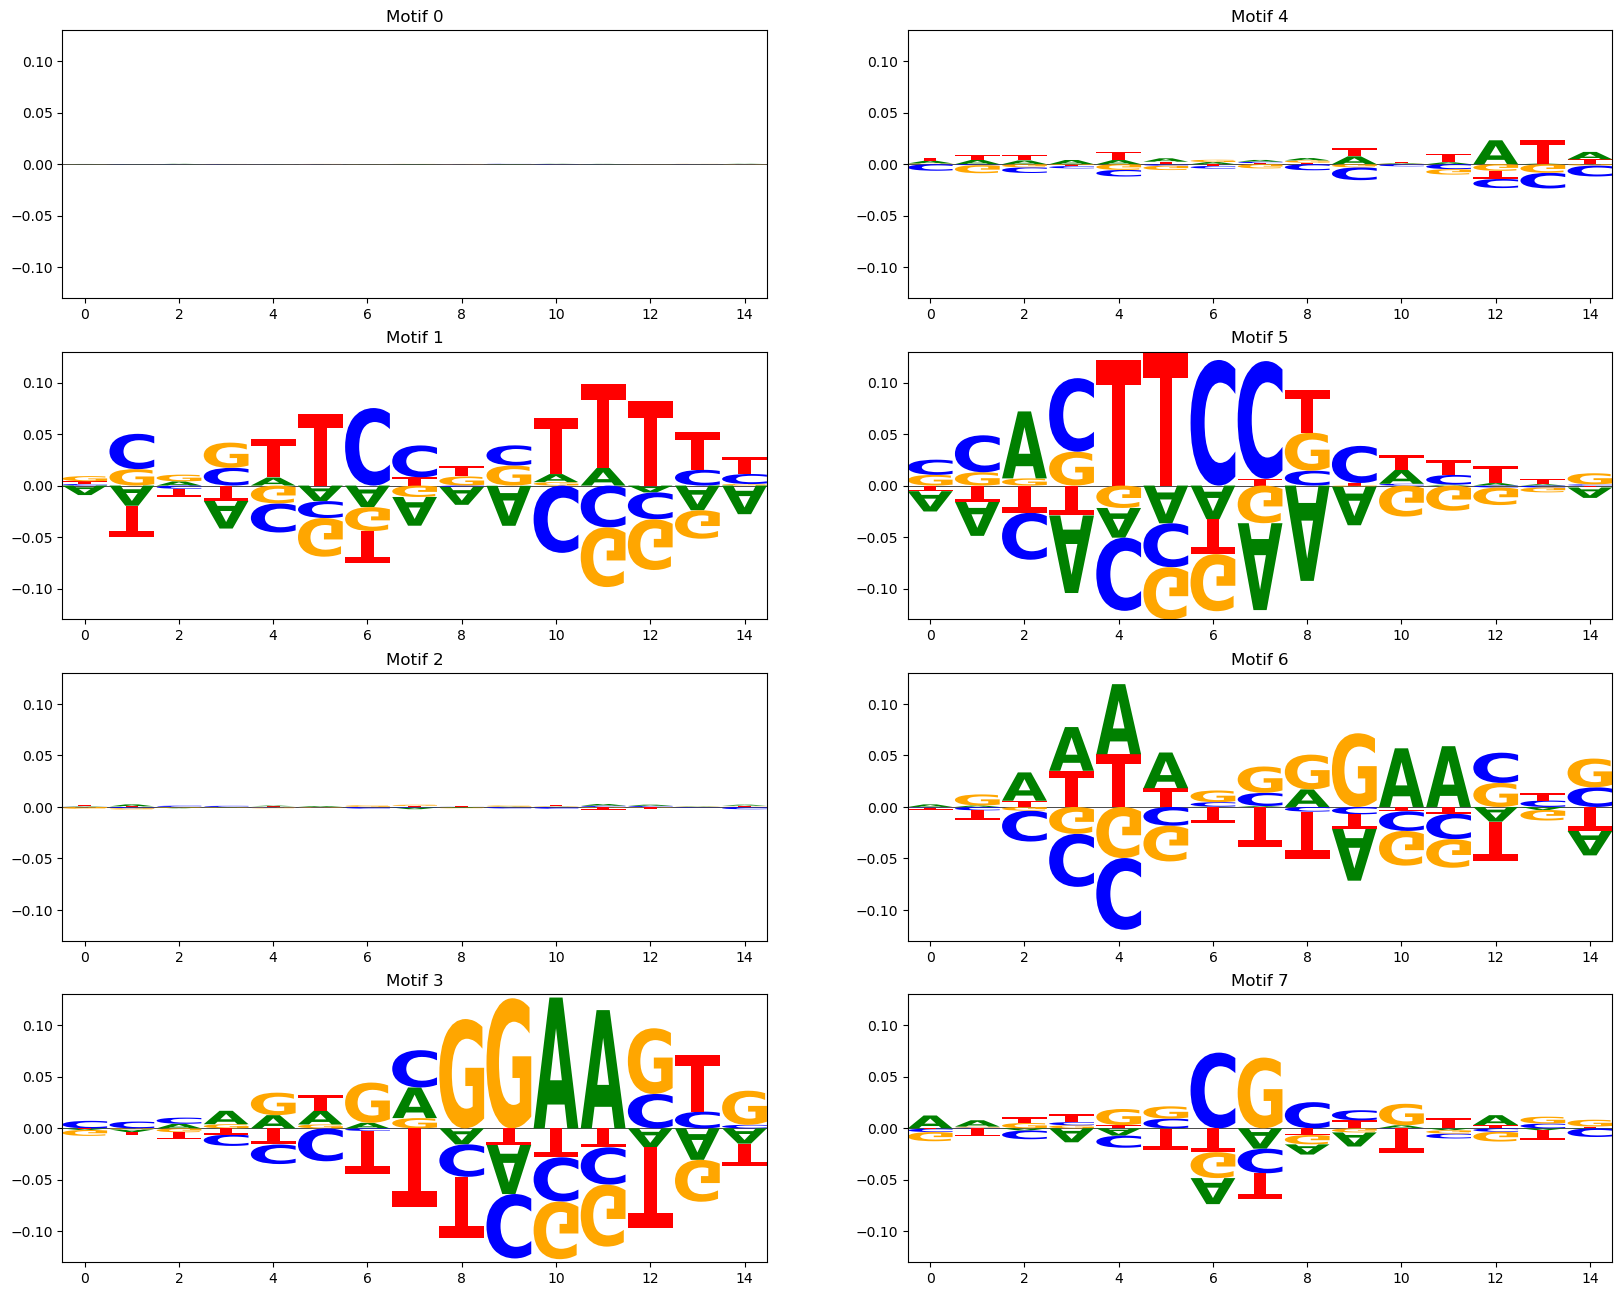

In [15]:
# Plot filter weights
num_cols = 2
num_rows = int(np.ceil(len(conv_weights) / 2))
fig, ax = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(20, num_rows * 4))
min_height = np.min(np.sum(np.minimum(conv_weights_centered, 0), axis=2))
max_height = np.max(np.sum(np.maximum(conv_weights_centered, 0), axis=2))
ylims = (min_height, max_height)
for filter_i in range(conv_weights.shape[0]):
    i, j = filter_i % num_rows, filter_i // num_rows
    create_dna_logo(conv_weights_centered[filter_i], ax=ax[i, j])
    ax[i, j].set_ylim(ylims)
    ax[i, j].set_title("Motif %d" % filter_i)
plt.show()

Alternatively, we can also convert each filter to a PFM by averaging together sub-sequences which highly activate each filter. We will use the test set for this.

In [16]:
# Run predictions on the test set and save the convolutional activations
model.eval()  # Set evaluation mode

test_loader.dataset.on_epoch_start()
t_iter = tqdm.notebook.tqdm(
    enumerate(test_loader), total=len(test_loader.dataset)
)

# Save the input sequences, convolutional activations, and attention scores
input_seqs, conv_acts, att_vals = [], [], []

for batch_i, batch in t_iter:
    x = batch[0]
    input_seqs.append(x)
    x = torch.tensor(x).float().to(DEVICE)
    
    _, interims = model(x, return_interims=True)
    conv_acts.append(interims["conv_acts"].detach().cpu().numpy())
    att_vals.append(interims["att_vals"].detach().cpu().numpy())

input_seqs = np.concatenate(input_seqs)  # Shape: N x L x 4
conv_acts = np.concatenate(conv_acts)  # Shape: N x (L - W + 1) x F
att_vals = np.concatenate(att_vals)  # Shape: N x NL x NH x (L - W + 1)

  0%|          | 0/31 [00:00<?, ?it/s]

In [17]:
# Now average together sub-sequences which highly activate each filter
max_thresh_frac = 0.5

num_filters = conv_acts.shape[2]
filter_width = input_seqs.shape[1] - conv_acts.shape[1] + 1

# Compute minimum activations needed
act_threshes = np.max(conv_acts, axis=(0, 1)) * max_thresh_frac

# Construct PFMs
pfms = np.zeros((num_filters, filter_width, 4))
for i in range(num_filters):
    if act_threshes[i] == 0:
        continue
    ex_inds, start_inds = np.where(conv_acts[:, :, i] > act_threshes[i])
    if not ex_inds.size:
        # Nothing passed the threshold
        continue
    # Trick to get all matching subsequences, where we flatten the set of all
    # indices we want and then reshape
    seqs = input_seqs[
        np.repeat(ex_inds, filter_width),
        (np.arange(filter_width)[None] + start_inds[:, None]).reshape(-1)
    ].reshape(len(ex_inds), filter_width, -1)
    pfms[i] = np.mean(seqs, axis=0)

In [18]:
BACKGROUND_FREQS = np.array([0.25, 0.25, 0.25, 0.25])
def pfm_info_content(pfm, pseudocount=0.001):
    """
    Given an L x 4 PFM, computes information content for each base and
    returns it as an L-array.
    """
    num_bases = pfm.shape[1]
    # Normalize track to probabilities along base axis
    pfm_norm = (pfm + pseudocount) / \
        (np.sum(pfm, axis=1, keepdims=True) + (num_bases * pseudocount))
    ic = pfm_norm * np.log2(pfm_norm / np.expand_dims(BACKGROUND_FREQS, axis=0))
    return np.sum(ic, axis=1)

/home/tsenga5/miniforge3/envs/mechint/lib/python3.12/site-packages/logomaker/src/Logo.py:1062: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  self.ax.set_ylim([ymin, ymax])
/home/tsenga5/miniforge3/envs/mechint/lib/python3.12/site-packages/logomaker/src/Logo.py:1062: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  self.ax.set_ylim([ymin, ymax])


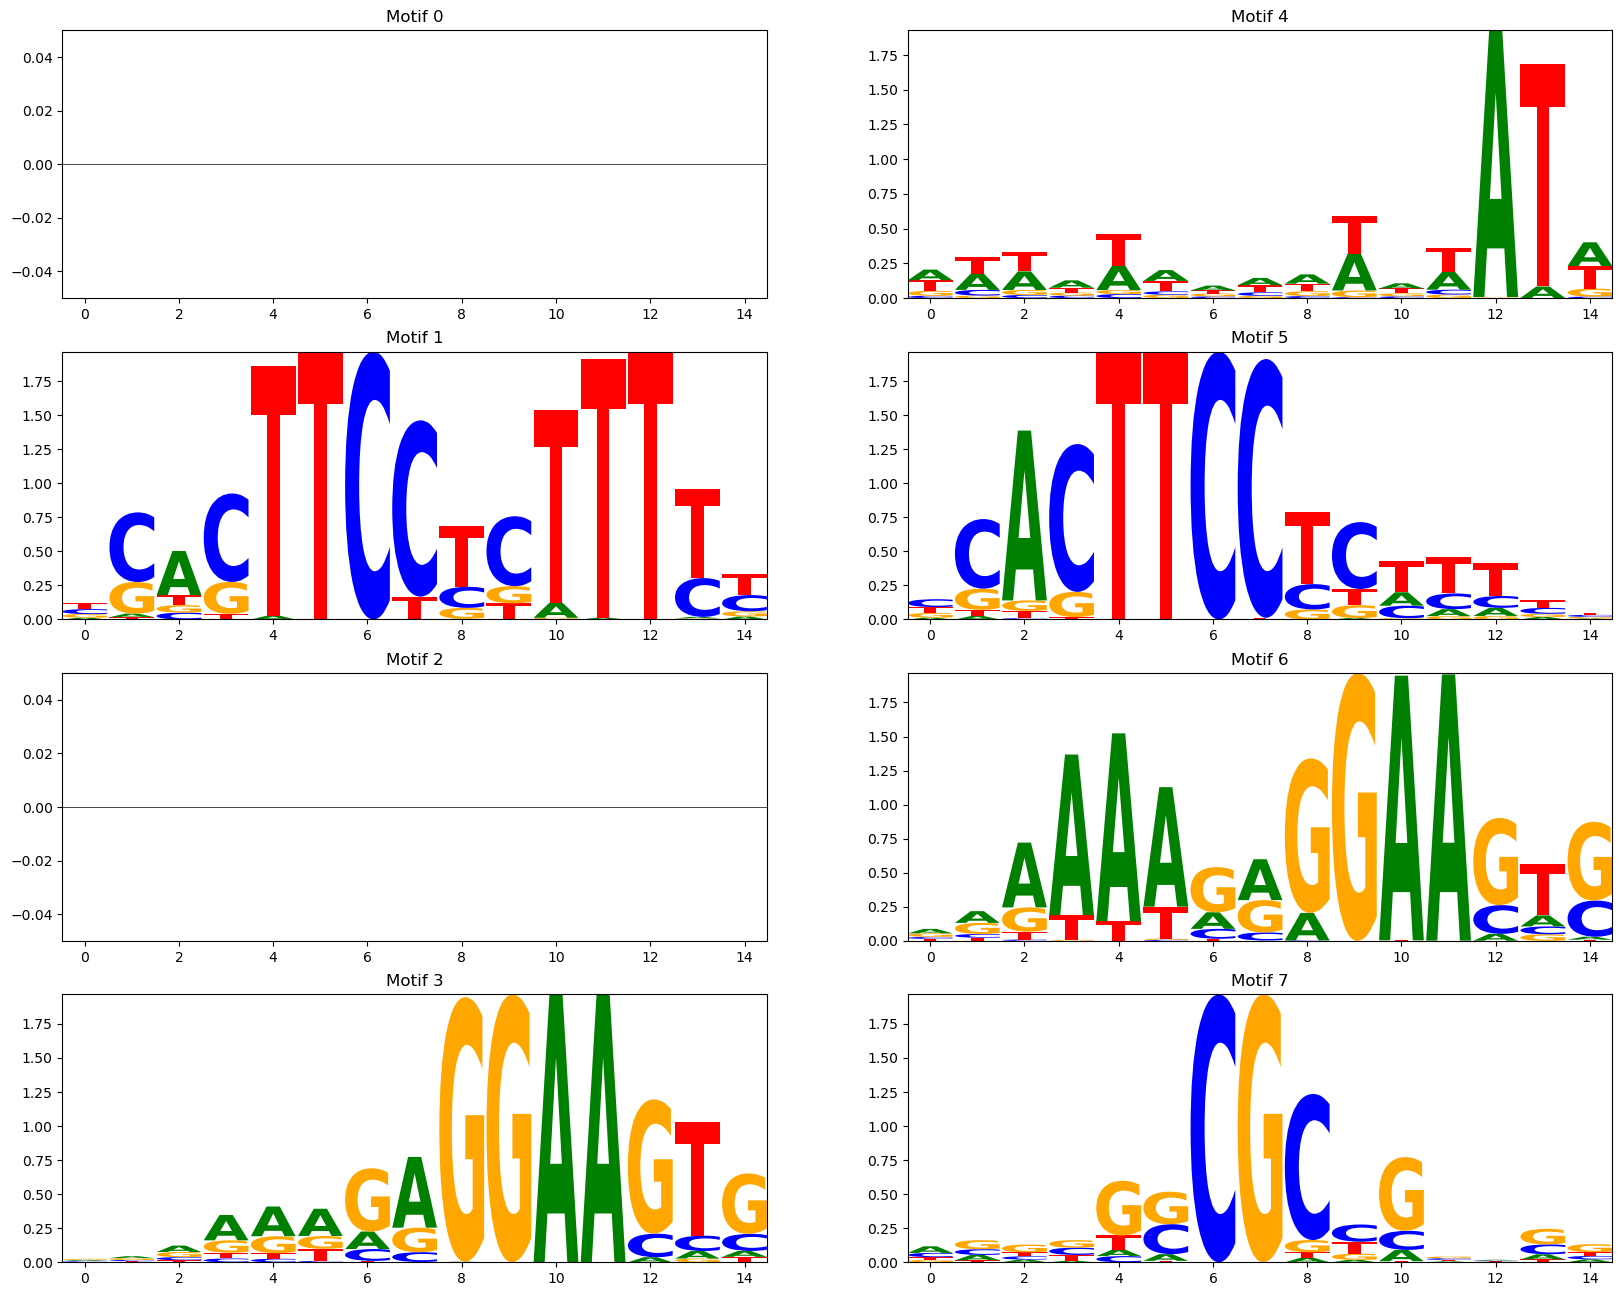

In [19]:
# Plot PWMs
num_cols = 2
num_rows = int(np.ceil(len(conv_weights) / 2))
fig, ax = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(20, num_rows * 4))
for filter_i in range(conv_weights.shape[0]):
    i, j = filter_i % num_rows, filter_i // num_rows
    create_dna_logo(pfms[filter_i] * pfm_info_content(pfms[filter_i])[:, None], ax=ax[i, j])
    ax[i, j].set_title("Motif %d" % filter_i)
plt.show()

### 6) Extract motif instances

Finally, let us see how to extract motif instances (for downstream syntax analysis). Here, we will use both the convolutional activations and the attention scores from the forward pass over the test set.

To call motif instances, we take positions of high attention score, and call a motif instance if there is a highly activated convolutional filter at that position.

In [20]:
motif_hits = []

# For each filter, get the average activation
filter_mean_acts = np.empty(conv_acts.shape[2])
for filter_i in range(conv_acts.shape[2]):
    acts = conv_acts[:, :, filter_i]
    acts = acts[acts > 0]  # Only positive activations
    filter_mean_acts[filter_i] = np.mean(acts)

# For each example, get the positions which had a high attention score
for ex_i in range(len(att_vals)):
    ex_att_vals = att_vals[ex_i]  # Shape: AL x AH x L'

    # Get positions with high attention score
    mask = np.any(ex_att_vals > 0.9, axis=(0, 1))  # Collapse over attention layers and heads
    inds = np.where(mask)[0]

    ex_motif_hits = []

    # For each position, figure out which motif/filter is firing
    for hit_pos in inds:
        acts = conv_acts[ex_i, hit_pos]
        filter_hits = acts > filter_mean_acts
        if not np.any(filter_hits):
            # Got a high attention score, but no motif hit here
            continue
        filter_inds = np.where(filter_hits)[0]
        ex_motif_hits.append((hit_pos, [i for i in filter_inds]))
    motif_hits.append(ex_motif_hits)        

/home/tsenga5/miniforge3/envs/mechint/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/tsenga5/miniforge3/envs/mechint/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


In [21]:
# Print out motif hits for the first 20 examples
print("Ex.\tMotif hits (position:[motifs], ...)")
for ex_i in range(20):
    print("%d\t%s" % (ex_i, ", ".join(["%d:[%s]" % (pair[0], "|".join([str(m) for m in pair[1]])) for pair in motif_hits[ex_i]])))

Ex.	Motif hits (position:[motifs], ...)
0	243:[5]
1	256:[5]
2	263:[5]
3	248:[3|4|6]
4	220:[5]
5	248:[3|6]
6	244:[5]
7	257:[3|6]
8	254:[1|5]
9	247:[3]
10	261:[5]
11	257:[3|6]
12	250:[5]
13	228:[5]
14	249:[1]
15	233:[5]
16	253:[3|4|6]
17	267:[5]
18	241:[1|5]
19	265:[5]
